## panan-rOM3 analysis notebook for T-S diagrams on the continental shelf

# Requires an XXLargeMem ARE session

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cmo
import gsw
from xhistogram.xarray import histogram as xhistogram
from matplotlib import ticker, cm, colors

import warnings
warnings.simplefilter("ignore")


In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43101,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33539,Total threads: 1
Dashboard: /proxy/40557/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:34797,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [6]:
catalog = intake.cat.access_nri

In [7]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}",{1mon},"{average_T1, congel_m, pot_temp, NCAT, vatm_m, sfc_salt_flux_ice, sea_levelsq, total_ocean_calving_heat, grid_xt_ocean, hs_m, surface_salt, alidr_ai_m, pot_rho_2, ty_trans_nrho_submeso, vert_pv, t..."


In [8]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{MOM6, SIS2}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{seaIce, ocean}","{1day, 1mon, fx}","{average_T1, intz_PFv_2d, areacello_cv, dvdt, Kd_ePBL, areacello_bu, dxCv, thetao, volcello, intz_rvxu_2d, yB, taux_bot, intz_PFu_2d, precip, gKEv, dv_dt_visc, deptho, wet, siconc, vmo, taux, geol..."


# T-S diagrams on continental shelf

Use Antarctic shelf masking from COSIMA RECIPES SWMT calculation: https://github.com/COSIMA/cosima-recipes/blob/main/03-Mains/Surface_Water_Mass_Transformation.ipynb

And gsw conversion and density contours from https://github.com/COSIMA/cosima-recipes/blob/main/03-Mains/Temperature_Salinity_Diagram.ipynb 

In [108]:
isobath1000 = '/g/data/x77/wf4500/MOM6_panan_ice_shelf/GH/mom6-panAn-iceshelf-tools/evaluation/isobath_1000m_8km_jra_ryf_obc_Charrassin.npz'
def shelf_mask_isobath(var, model_dict):
    '''
    Masks ACCESS-OM2-01 and Pan-Antarctic variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison. Panan isobath created by Christina Schmidt"
    Only to be used with ACCESS-OM2-0.1 and Pan-Antarctic output!
    '''

    '''
    Copied from https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Mains-Advanced/Surface_Water_Mass_Transformation.ipynb
    '''

    paths = {
             "access-rom3-panan":isobath1000,
             "ACCESS-OM2-01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "panant-01-zstar-ACCESSyr2": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             "panant-005-zstar-ACCESSyr2": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc",     
             }

    var = var.sel({'yh': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [98]:
def shelf_mask_isobathom2(var, model_dict):
    '''
    Masks ACCESS-OM2-01 and Pan-Antarctic variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison. Panan isobath created by Christina Schmidt"
    Only to be used with ACCESS-OM2-0.1 and Pan-Antarctic output!
    '''

    '''
    Copied from https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Mains-Advanced/Surface_Water_Mass_Transformation.ipynb
    '''

    paths = {
             "access-rom3-panan":isobath1000,
             "ACCESS-OM2-01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "panant-01-zstar-ACCESSyr2": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     

             }

    var = var.sel({'yt_ocean': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [69]:
volcello = esm_datastore.search(variable="volcello",file_id = 'ocean_month_z').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).volcello
volcello = volcello.isel(time = 0).sel({'yh': slice(-90, -59)})

In [70]:
depth = esm_datastore.search(variable="deptho").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'access-rom3-panan')
shelf_mask = shelf_mask.load()

In [71]:
# define a time slice for the 10th year (panant01 and 005 start at 1991, accessom2 and panantrom3 start at 1900)
time_slice = np.arange(9*12,9*12+12)
time_slice

array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

In [72]:
panantrom3_T = esm_datastore.search(variable="thetao", frequency = '1mon', file_id = 'access_om3_mom6_3d_thetao_1mon_mean_XXXX').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).thetao#, 'chunks':{'yh':1442,'xh':1000}}).thetao
panantrom3_S = esm_datastore.search(variable="so", frequency = '1mon', file_id = 'access_om3_mom6_3d_so_1mon_mean_XXXX').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).so#, 'chunks':{'yh':1442,'xh':1000}}).so

panantrom3_T = panantrom3_T.isel(time = time_slice).sel({'yh': slice(-90, -59)})
panantrom3_S = panantrom3_S.isel(time = time_slice).sel({'yh': slice(-90, -59)})

temp_shelf = shelf_mask*(panantrom3_T.mean('time'))
salt_shelf = shelf_mask*(panantrom3_S.mean('time'))
volcello_shelf = shelf_mask*volcello

temp_shelf = temp_shelf.load()
salt_shelf = salt_shelf.load()

In [73]:
# convert to absolute salinity
def gsw_SA_from_SP(salt):
    """function to convert practical salinity to absolute salinity
    using the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
    (https://teos-10.github.io/GSW-Python/)
    
    input:
        -salt: practical salinity (array)
        -lon_name: name of the longitude (str)
    output:
        -salt_abs: absolute salinity (array)
    """

    '''
    modified from https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Mains-Advanced/Temperature_Salinity_Diagram.ipynb
    '''
    
    pres = gsw.p_from_z(-salt.zl, salt.yh)
    salt_abs = gsw.SA_from_SP(salt, pres, salt, salt.yh)
    salt_abs.attrs = {'units': 'Absolute Salinity (g/kg)'}
    return salt_abs

In [74]:
# convert to absolute salinity
def gsw_SA_from_SPpanan(salt):
    """function to convert practical salinity to absolute salinity
    using the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
    (https://teos-10.github.io/GSW-Python/)
    
    input:
        -salt: practical salinity (array)
        -lon_name: name of the longitude (str)
    output:
        -salt_abs: absolute salinity (array)
    """

    '''
    modified from https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Mains-Advanced/Temperature_Salinity_Diagram.ipynb
    '''
    
    pres = gsw.p_from_z(-salt.z_l, salt.yh)
    salt_abs = gsw.SA_from_SP(salt, pres, salt, salt.yh)
    salt_abs.attrs = {'units': 'Absolute Salinity (g/kg)'}
    return salt_abs

In [94]:
# convert to absolute salinity
def gsw_SA_from_SPom2(salt):
    """function to convert practical salinity to absolute salinity
    using the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10
    (https://teos-10.github.io/GSW-Python/)
    
    input:
        -salt: practical salinity (array)
        -lon_name: name of the longitude (str)
    output:
        -salt_abs: absolute salinity (array)
    """

    '''
    modified from https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Mains-Advanced/Temperature_Salinity_Diagram.ipynb
    '''
    
    pres = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
    salt_abs = gsw.SA_from_SP(salt, pres, salt, salt.yt_ocean)
    salt_abs.attrs = {'units': 'Absolute Salinity (g/kg)'}
    return salt_abs

In [75]:
salt_shelf_abs = gsw_SA_from_SP(salt_shelf)
temp_shelf_con = gsw.conversions.CT_from_pt(salt_shelf_abs, temp_shelf)

In [76]:
salt_shelf_abs.name = "salt"
temp_shelf_con.name = "temp"
volcello_shelf.name = "volume"

salt_shelf_abs =salt_shelf_abs.load()
temp_shelf_con = temp_shelf_con.load()
volcello_shelf = volcello_shelf.load()

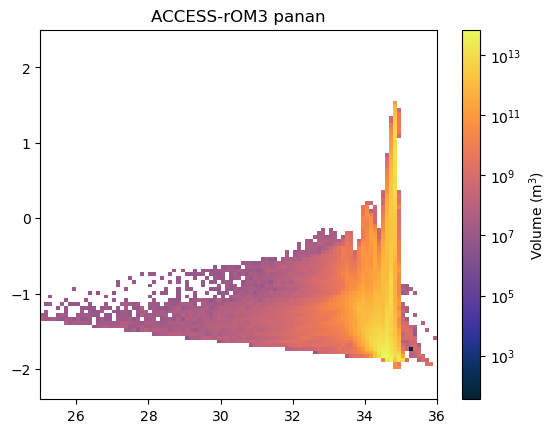

In [77]:
salt_bins = np.linspace(25,36,100)
temp_bins = np.linspace(-2.4,2.5,100)

# TS_hist = xhistogram(
#         temp_shelf_con01, salt_shelf_abs01, 
#     bins=(temp_bins, salt_bins), weights=volcello_shelf01.fillna(0))

TS_hist,Ts,Ss = np.histogram2d(np.ndarray.flatten(temp_shelf_con.values),
                         np.ndarray.flatten(salt_shelf_abs.values),
                         bins=(temp_bins, salt_bins), 
                         weights=np.ndarray.flatten(volcello_shelf.fillna(0).values))
#TS_hist = TS_hist.where(TS_hist != 0).compute()
TS_hist = np.where(TS_hist!=0,TS_hist,np.nan)

log_levels = np.logspace(np.log10(1e12), np.log10(1e16), 50)

# TS_hist.plot(cmap=cm.cm.thermal, levels=log_levels, norm=colors.LogNorm(),
#              cbar_kwargs=dict(label='volume ($m^{3}$)'))
plt.pcolormesh(Ss,Ts,TS_hist,cmap=cmo.cm.thermal, 
               norm=colors.LogNorm(),)
plt.title('ACCESS-rOM3 panan')
plt.colorbar(label = 'Volume (m$^3$)')

In [ ]:
# salt_bins = np.linspace(29,36,100)
# temp_bins = np.linspace(-2.2,2.5,100)

# TS_hist = xhistogram(
#         temp_shelf_con, salt_shelf_abs, bins=(temp_bins, salt_bins), weights=volcello_shelf.fillna(0))
# TS_hist = TS_hist.where(TS_hist != 0).compute()
# log_levels = np.logspace(np.log10(1e12), np.log10(1e16), 50)

# TS_hist.plot(cmap=cm.cm.thermal, levels=log_levels, norm=colors.LogNorm(),
#              cbar_kwargs=dict(label='volume ($m^{3}$)'))
# plt.title('ACCESS-rOM3 panan')

Now repeat for panan-01

In [53]:
experiment = 'panant-01-zstar-ACCESSyr2'

volcello01 = catalog[experiment].search(variable="volcello", file_id = 'ocean.1mon.nv:2.xh:3600.xq:3601.yh:845.yq:846.z_i:76.z_l:75').to_dask(xarray_open_kwargs={'decode_timedelta':True})
volcello01 = volcello01.volcello.isel(time = 0).sel({'yh': slice(-90, -59)})
depth01 = catalog[experiment].search(variable="deptho").to_dask(xarray_open_kwargs={'decode_timedelta':True})
land_mask01 = (depth01*0).fillna(1)
depth_shelf01, shelf_mask01 = shelf_mask_isobath(depth01, experiment)
shelf_mask01 = shelf_mask01.load()
panant01_T = catalog[experiment].search(variable="thetao",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).thetao
panant01_S = catalog[experiment].search(variable="so",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).so
panant01_T = panant01_T.isel(time = time_slice).sel({'yh': slice(-90, -59)})
panant01_S = panant01_S.isel(time = time_slice).sel({'yh': slice(-90, -59)})
temp_shelf01 = shelf_mask01*(panant01_T.mean('time'))
salt_shelf01 = shelf_mask01*(panant01_S.mean('time'))
volcello_shelf01 = shelf_mask01*volcello01

temp_shelf01 = temp_shelf01.load()
salt_shelf01 = salt_shelf01.load()
salt_shelf_abs01 = gsw_SA_from_SPpanan(salt_shelf01)
temp_shelf_con01 = gsw.conversions.CT_from_pt(salt_shelf_abs01, temp_shelf01)
salt_shelf_abs01.name = "salt"
temp_shelf_con01.name = "temp"
volcello_shelf01.name = "volume"
salt_shelf_abs01 =salt_shelf_abs01.load()
temp_shelf_con01 = temp_shelf_con01.load()
volcello_shelf01 = volcello_shelf01.load()

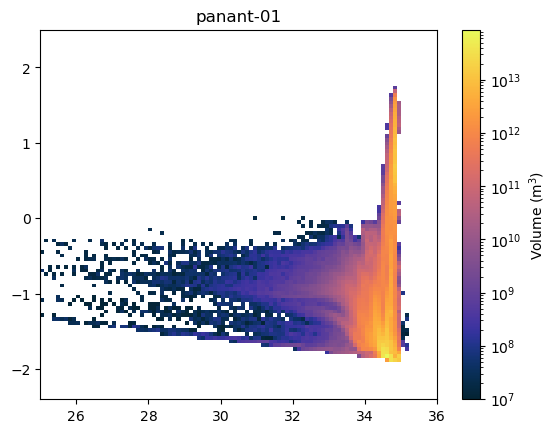

In [79]:
salt_bins = np.linspace(25,36,100)
temp_bins = np.linspace(-2.4,2.5,100)

# TS_hist = xhistogram(
#         temp_shelf_con01, salt_shelf_abs01, 
#     bins=(temp_bins, salt_bins), weights=volcello_shelf01.fillna(0))

TS_hist01,Ts,Ss = np.histogram2d(np.ndarray.flatten(temp_shelf_con01.values),
                         np.ndarray.flatten(salt_shelf_abs01.values),
                         bins=(temp_bins, salt_bins), 
                         weights=np.ndarray.flatten(volcello_shelf01.fillna(0).values))
#TS_hist = TS_hist.where(TS_hist != 0).compute()
TS_hist01 = np.where(TS_hist01!=0,TS_hist01,np.nan)

log_levels = np.logspace(np.log10(1e12), np.log10(1e16), 50)

# TS_hist.plot(cmap=cm.cm.thermal, levels=log_levels, norm=colors.LogNorm(),
#              cbar_kwargs=dict(label='volume ($m^{3}$)'))
plt.pcolormesh(Ss,Ts,TS_hist01,cmap=cmo.cm.thermal, 
               norm=colors.LogNorm(),)
plt.title('panant-01')
plt.colorbar(label = 'Volume (m$^3$)')

repeat for panan-005

In [115]:
experiment = 'panant-005-zstar-ACCESSyr2'

volcello005 = catalog[experiment].search(variable="volcello",file_id = 'ocean.1mon.nv:2.xh:7200.xq:7201.yh:1690.yq:1691.z_i:76.z_l:75').to_dask(xarray_open_kwargs={'decode_timedelta':True})
volcello005 = volcello005.volcello.isel(time = 0).sel({'yh': slice(-90, -59)})
depth005 = catalog[experiment].search(variable="deptho").to_dask(xarray_open_kwargs={'decode_timedelta':True})
land_mask005 = (depth005*0).fillna(1)
depth_shelf005, shelf_mask005 = shelf_mask_isobath(depth005, experiment)
shelf_mask005 = shelf_mask005.load()
panant005_T = catalog[experiment].search(variable="thetao",frequency='1mon',
                                        file_id = 'ocean.1mon.nv:2.xh:7200.xq:7201.yh:1690.yq:1691.z_i:76.z_l:75'
                                        ).to_dask(xarray_open_kwargs={'decode_timedelta':True}).thetao
panant005_S = catalog[experiment].search(variable="so",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).so
panant005_T = panant005_T.isel(time = time_slice).sel({'yh': slice(-90, -59)})
panant005_S = panant005_S.isel(time = time_slice).sel({'yh': slice(-90, -59)})
temp_shelf005 = shelf_mask005*(panant005_T.mean('time'))
salt_shelf005 = shelf_mask005*(panant005_S.mean('time'))
volcello_shelf005 = shelf_mask005*volcello005

temp_shelf005 = temp_shelf005.load()
salt_shelf005 = salt_shelf005.load()
salt_shelf_abs005 = gsw_SA_from_SPpanan(salt_shelf005)
temp_shelf_con005 = gsw.conversions.CT_from_pt(salt_shelf_abs005, temp_shelf005)
salt_shelf_abs005.name = "salt"
temp_shelf_con005.name = "temp"
volcello_shelf005.name = "volume"
salt_shelf_abs005 =salt_shelf_abs005.load()
temp_shelf_con005 = temp_shelf_con005.load()
volcello_shelf005 = volcello_shelf005.load()


salt_bins = np.linspace(25,36,100)
temp_bins = np.linspace(-2.4,2.5,100)


TS_hist005,Ts,Ss = np.histogram2d(np.ndarray.flatten(temp_shelf_con005.values),
                         np.ndarray.flatten(salt_shelf_abs005.values),
                         bins=(temp_bins, salt_bins), 
                         weights=np.ndarray.flatten(volcello_shelf005.fillna(0).values))
TS_hist005 = np.where(TS_hist005!=0,TS_hist005,np.nan)


2025-09-19 12:45:46,600 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7.22 GiB -- Worker memory limit: 8.97 GiB
2025-09-19 12:45:48,550 - distributed.worker.memory - WARNING - Worker is at 62% memory usage. Resuming worker. Process memory: 5.65 GiB -- Worker memory limit: 8.97 GiB
2025-09-19 12:47:46,666 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 7.37 GiB -- Worker memory limit: 8.97 GiB
2025-09-19 12:47:48,431 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 5.29 GiB -- Worker memory limit: 8.97 GiB
2025-09-19 12:49:02,882 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 7.26 GiB -- Worker memory limit: 8.97 GiB
2025-09-19 12:49:04,586 - distributed.worker.memory - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 5.30 GiB -- Worker mem

repeat for ACCESS-OM2-01

In [118]:
experiment = '01deg_jra55v13_ryf9091'

areaom2 = catalog[experiment].search(variable="area_t").to_dask(xarray_open_kwargs={'decode_timedelta':True}).area_t
dztom2 = catalog[experiment].search(variable="dzt",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).dzt
volcelloom2 = areaom2*dztom2.isel(time = 0).sel({'yt_ocean': slice(-90, -59)})
depthom2 = catalog[experiment].search(variable="ht").to_dask(xarray_open_kwargs={'decode_timedelta':True})
land_maskom2 = (depthom2*0).fillna(1)
depth_shelfom2, shelf_maskom2 = shelf_mask_isobathom2(depthom2, "ACCESS-OM2-01")
shelf_maskom2 = shelf_maskom2.load()
panantom2_T = catalog[experiment].search(variable="temp",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).temp
panantom2_S = catalog[experiment].search(variable="salt",frequency='1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).salt
panantom2_T = panantom2_T.isel(time = time_slice).sel({'yt_ocean': slice(-90, -59)})
panantom2_S = panantom2_S.isel(time = time_slice).sel({'yt_ocean': slice(-90, -59)})
temp_shelfom2 = shelf_maskom2*(panantom2_T.mean('time'))
salt_shelfom2 = shelf_maskom2*(panantom2_S.mean('time'))
volcello_shelfom2 = shelf_maskom2*volcelloom2

temp_shelf_conom2 = temp_shelfom2.load() #already conservative temp
salt_shelfom2 = salt_shelfom2.load()
salt_shelf_absom2 = gsw_SA_from_SPom2(salt_shelfom2)
#temp_shelf_conom2 = gsw.conversions.CT_from_pt(salt_shelf_absom2, temp_shelfom2)
salt_shelf_absom2.name = "salt"
temp_shelf_conom2.name = "temp"
volcello_shelfom2.name = "volume"
salt_shelf_absom2 =salt_shelf_absom2.load()
temp_shelf_conom2 = temp_shelf_conom2.load() - 273.15
volcello_shelfom2 = volcello_shelfom2.load()

salt_bins = np.linspace(25,36,100)
temp_bins = np.linspace(-2.4,2.5,100)

# TS_hist = xhistogram(
#         temp_shelf_con01, salt_shelf_abs01, 
#     bins=(temp_bins, salt_bins), weights=volcello_shelf01.fillna(0))

TS_histom2,Ts,Ss = np.histogram2d(np.ndarray.flatten(temp_shelf_conom2.values),
                         np.ndarray.flatten(salt_shelf_absom2.values),
                         bins=(temp_bins, salt_bins), 
                         weights=np.ndarray.flatten(volcello_shelfom2.fillna(0).values))
#TS_hist = TS_hist.where(TS_hist != 0).compute()
TS_histom2 = np.where(TS_histom2!=0,TS_histom2,np.nan)


In [85]:
# To create density contours in the T-S diagram
temp_bins_mesh, salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
TS_density = gsw.density.sigma2(salt_bins_mesh, temp_bins_mesh)


Text(0.5, 0.98, 'Temperature-Salinity diagrams on the continental shelf, average of year 10')

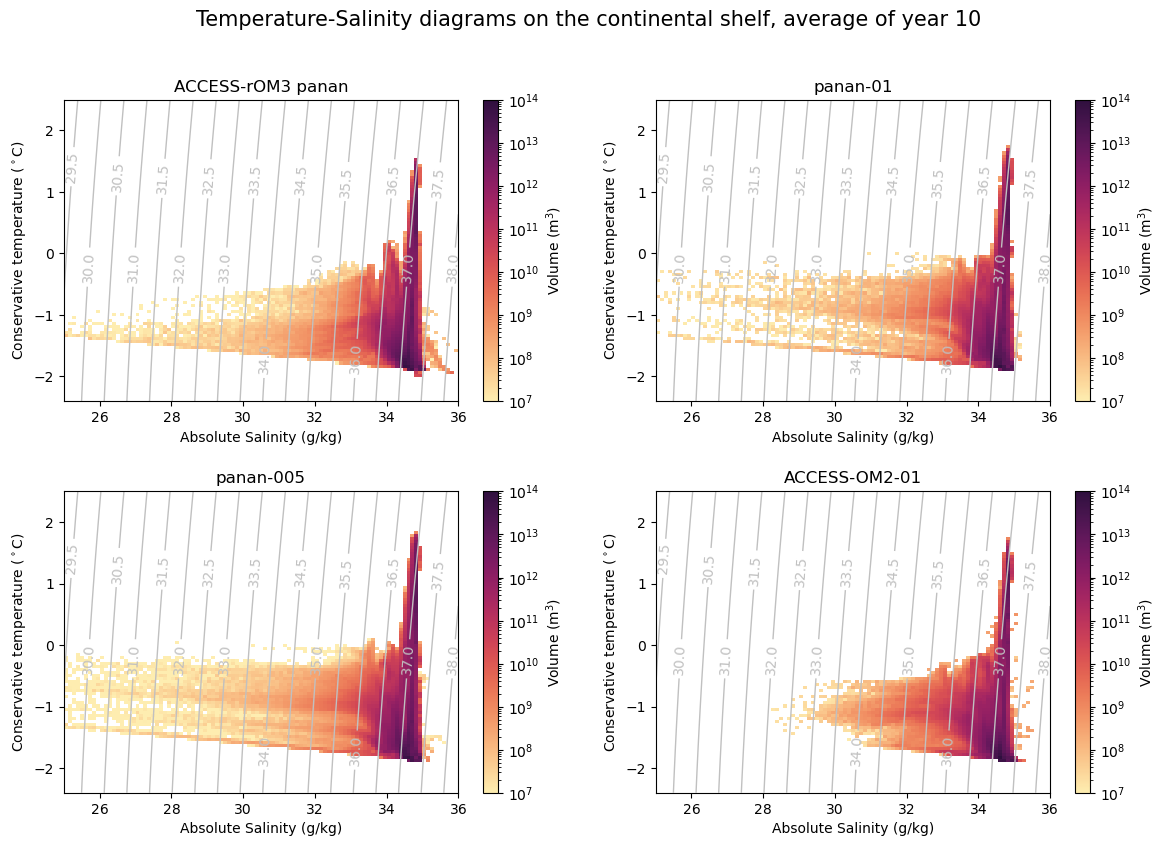

In [127]:
# Plot together

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (14,9))

axes = np.ravel(ax)

a = axes[0].pcolormesh(Ss,Ts,TS_hist,cmap=cmo.cm.matter, 
               norm=colors.LogNorm(vmin = 1e7, vmax = 1e14))
plt.colorbar(a, label = 'Volume (m$^3$)')
# Add the density contours
cs = axes[0].contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)
axes[0].set_title('ACCESS-rOM3 panan')
axes[0].set_ylabel('Conservative temperature ($^\circ$C)')
axes[0].set_xlabel('Absolute Salinity (g/kg)')

a = axes[1].pcolormesh(Ss,Ts,TS_hist01,cmap=cmo.cm.matter, 
               norm=colors.LogNorm(vmin = 1e7, vmax = 1e14))
plt.colorbar(a, label = 'Volume (m$^3$)')
cs = axes[1].contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)
axes[1].set_title('panan-01')
axes[1].set_ylabel('Conservative temperature ($^\circ$C)')
axes[1].set_xlabel('Absolute Salinity (g/kg)')

a = axes[2].pcolormesh(Ss,Ts,TS_hist005,cmap=cmo.cm.matter, 
               norm=colors.LogNorm(vmin = 1e7, vmax = 1e14))
plt.colorbar(a, label = 'Volume (m$^3$)')
cs = axes[2].contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)
axes[2].set_title('panan-005')
axes[2].set_ylabel('Conservative temperature ($^\circ$C)')
axes[2].set_xlabel('Absolute Salinity (g/kg)')

a = axes[3].pcolormesh(Ss,Ts,TS_histom2,cmap=cmo.cm.matter, 
               norm=colors.LogNorm(vmin = 1e7, vmax = 1e14))
plt.colorbar(a, label = 'Volume (m$^3$)')
cs = axes[3].contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)
axes[3].set_title('ACCESS-OM2-01')
axes[3].set_ylabel('Conservative temperature ($^\circ$C)')
axes[3].set_xlabel('Absolute Salinity (g/kg)')

fig.subplots_adjust(hspace = 0.3)
fig.suptitle('Temperature-Salinity diagrams on the continental shelf, average of year 10', fontsize = 15)

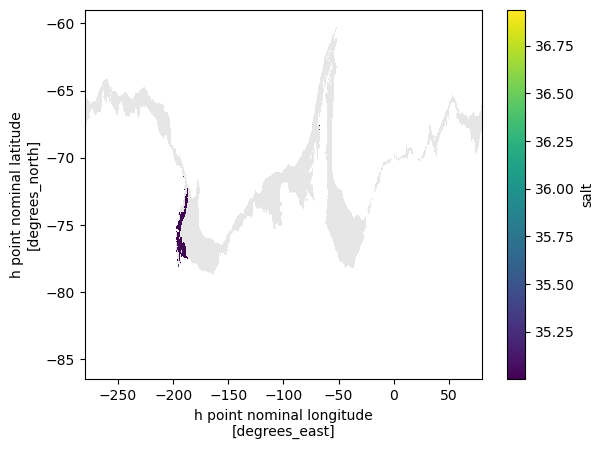

In [126]:
salt_shelf_abs.max('zl').where(salt_shelf_abs.max('zl')>35).plot()
salt_shelf_abs.max('zl').plot(alpha = 0.1, cmap = 'Greys', add_colorbar = False)
